# Exploratory Data Analysis

##### *In which we learn more about crabs and clean up the dataset.*

###### [GitHub Repository](https://github.com/ahester57/ai_workshop/tree/master/notebooks/time_for_crab/0-eda)

###### [Notebook Viewer](https://nbviewer.jupyter.org/github/ahester57/ai_workshop/blob/master/notebooks/time_for_crab/0-eda/eda.ipynb)

###### [Kaggle Dataset](https://www.kaggle.com/sidhus/crab-age-prediction)


## Table of Contents

1. [Introduction](#Introduction)
2. [Reasons for Choosing This Dataset](#Reasons-for-Choosing-This-Dataset)
3. [Dataset Details](#Dataset-Details)
    1. [Columns](#Columns)
    2. [Define Constants](#Define-Constants)
    3. [Import Libraries](#Import-Libraries)
4. [Exploratory Data Analysis](#Exploratory-Data-Analysis)
    1. [Load the Data from CSV](#Load-the-Data-from-CSV)
    2. [Reduce Memory Usage](#Reduce-Memory-Usage)
    3. [Examine the Data](#Examine-the-Data)
    4. [Cleanup the Crabs](#Cleanup-the-Crabs)
    5. [Data Visualization](#Data-Visualization)
        1. [Data Distribution](#Data-Distribution)
            1. [Show the Histograms](#Show-the-Histograms)
            2. [Show the Box Plots](#Show-the-Box-Plots)
        2. [Data Cleanup from Observations](#More-Data-Cleanup-from-Observations)
    6. [Data Correlation](#Data-Correlation)
        1. [Show the Heatmap](#Show-the-Heatmap)
        2. [Show the Pair Plot](#Show-the-Pair-Plot)
    7. [Save the Data](#Save-the-Data)
    8. [Onwards to Overfitting](#Onwards-to-Overfitting)


## Introduction

Crabs are here, and they're mighty tasty.

Knowing how old they are helps identify full-sized crabs that are ready for the pot.
 
![Crab](https://upload.wikimedia.org/wikipedia/commons/b/b1/Mud_crab%2C_Scylla_serrate.jpg?20220920192756)

Prediction (regression) of mud crab age based on physical features.

## Reasons for Choosing This Dataset

A good dataset is the foundation of a good model.

##### My reasons

- Highly-rated tabular data with a natural prediction target (Age).
- Regression task since I like a challenge.
- Features easy to conceptualize for feature engineering.
- On the smaller side to quickly iterate on.
- Crabs are cool.

##### Reasons given by the [dataset on Kaggle](https://www.kaggle.com/datasets/sidhus/crab-age-prediction)

> Its a great starting point for classical regression analysis and feature engineering and understand the impact of feature engineering in Data Science domain.
> For a commercial crab farmer knowing the right age of the crab helps them decide if and when to harvest the crabs. Beyond a certain age, there is negligible growth in crab's physical characteristics and hence, it is important to time the harvesting to reduce cost and increase profit.

## Dataset Details

### Columns

The dataset contains the following columns:

---

| Column Name    | Description                                                                                         |
|----------------|-----------------------------------------------------------------------------------------------------|
| Sex            | Gender of the Crab - Male, Female and Indeterminate.                                                |
| Length         | Length of the Crab (in Feet; 1 foot = 30.48 cms)                                                    |
| Diameter       | Diameter of the Crab (in Feet; 1 foot = 30.48 cms)                                                  |
| Height         | Height of the Crab (in Feet; 1 foot = 30.48 cms)                                                    |
| Weight         | Weight of the Crab (in ounces; 1 Pound = 16 ounces)                                                 |
| Shucked Weight | Weight without the shell (in ounces; 1 Pound = 16 ounces)                                           |
| Viscera Weight | is weight that wraps around your abdominal organs deep inside body (in ounces; 1 Pound = 16 ounces) |
| Shell Weight   | Weight of the Shell (in ounces; 1 Pound = 16 ounces)                                                |
| Age            | Age of the Crab (in months)                                                                         |


### Define Constants

The PREDICTION_TARGET constant defines the column from the dataset which we will predict. 'Age' is the target column in this case.


In [26]:
%%time
DATASET_FILE = '../datasets/CrabAgePrediction.csv' # 'https://www.kaggle.com/sidhus/crab-age-prediction/download' or './data/CrabAgePrediction.csv'
NEXT_CACHE_FILE = '../cache/crabs.feather'
NEXT_NOTEBOOK = '../0-eda/overfit.ipynb'

PREDICTION_TARGET = 'Age'               # 'Age' is predicted
DATASET_COLUMNS = ['Sex','Length','Diameter','Height','Weight','Shucked Weight','Viscera Weight','Shell Weight',PREDICTION_TARGET]
REQUIRED_COLUMNS = [PREDICTION_TARGET]  # 'Age' is required

VALIDATION_SPLIT = 0.2


CPU times: total: 0 ns
Wall time: 0 ns


### Import Libraries

In [27]:
%%time
from notebooks.time_for_crab.mlutils import data_downcasting, display_df

import numpy as np
import pandas as pd
import pathlib

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

pd.set_option('mode.copy_on_write', True)


CPU times: total: 0 ns
Wall time: 1 ms


## Exploratory Data Analysis

Get that pot of water ready. It's crab cookin' time.

![Crab pot](https://chefscornerstore.com/product_images/uploaded_images/steaming-crabs.jpg)

### Load the Data from CSV

Analyzing the output here will help us revise our data cleanup and augmentation functions.

The initial data is in CSV format. We will load it into a pandas DataFrame.  
We will ultimately save it to a `feather` file for easier loading in the next steps.


In [28]:
%%time
crabs = pd.read_csv(DATASET_FILE)  # load the data
display_df(crabs, show_info=True, show_missing=True, show_distinct=True)


DataFrame shape: (3893, 9)
First 5 rows:
  Sex  Length  Diameter  Height     Weight  Shucked Weight  Viscera Weight  \
0   F  1.4375    1.1750  0.4125  24.635715       12.332033        5.584852   
1   M  0.8875    0.6500  0.2125   5.400580        2.296310        1.374951   
2   I  1.0375    0.7750  0.2500   7.952035        3.231843        1.601747   
3   F  1.1750    0.8875  0.2500  13.480187        4.748541        2.282135   
4   I  0.8875    0.6625  0.2125   6.903103        3.458639        1.488349   

   Shell Weight  Age  
0      6.747181    9  
1      1.559222    6  
2      2.764076    6  
3      5.244657   10  
4      1.700970    6  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3893 entries, 0 to 3892
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             3893 non-null   object 
 1   Length          3893 non-null   float64
 2   Diameter        3893 non-null   float64
 3   Height          

### Reduce Memory Usage

Crabs were never known for their memory. Let's minimize the memory of our DataFrame using the smallest data types to fit the data.

The reason for this is to save computational resources and time. The smaller the data container, the faster the processing.


In [29]:
%%time
crabs = data_downcasting(crabs)
display_df(crabs, show_info=True, show_missing=True, show_distinct=True)


Memory usage of dataframe is 0.2674 MB (before)
Memory usage of dataframe is 0.0855 MB (after)
Reduced 68.0%
DataFrame shape: (3893, 9)
First 5 rows:
  Sex    Length  Diameter    Height     Weight  Shucked Weight  \
0   F  1.437500  1.174805  0.412598  24.640625       12.335938   
1   M  0.887695  0.649902  0.212524   5.402344        2.296875   
2   I  1.037109  0.774902  0.250000   7.953125        3.232422   
3   F  1.174805  0.887695  0.250000  13.476562        4.750000   
4   I  0.887695  0.662598  0.212524   6.902344        3.458984   

   Viscera Weight  Shell Weight  Age  
0        5.585938      6.746094    9  
1        1.375000      1.559570    6  
2        1.601562      2.763672    6  
3        2.281250      5.246094   10  
4        1.488281      1.701172    6  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3893 entries, 0 to 3892
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             38

### Examine the Data

Now we make sure the crabs will easily digest in our model.

#### Missing Values

No missing values! We're off to a good start with this dataset. *Will crab be on the menu tonight?*

#### Non-numeric Data

It looks like 'Sex' is a categorical variable. We'll need to convert this to a numeric value. Let's use **one-hot encoding**.


### Cleanup the Crabs

Dirty data is no good for crabs. Let's clean it up.

![How to clean a crab](https://www.recipetineats.com/wp-content/uploads/2021/07/Cleaning-and-preparing-crab-template-2.jpg)

#### Crab Cleaning Steps

- ~~Drop rows missing required columns~~.
    - E.g., 'Age'. 
- ~~Drop rows missing too many values~~.
    - E.g., more than 3 missing values.
- ~~Convert natural booleans to 0/1~~.
    - E.g., Y/N to 0/1.
- ~~Fill nulls for typically-binary variables with the median~~.
- ~~Fill nulls for typically-continuous variables with the median~~.
- ~~Fill nulls for typically-text variables with empty strings~~.
- One-hot encode categorical variables.
    - This should handle nulls for categorical variables.

~~Strike-throughs~~ ended up not being needed for this dataset.

#### Avoid Data Leakage!

While cleaning the data during EDA, we should avoid data leakage.

- Do not use test data to normalize values.
- Avoid filling missing values with the mean or median of the entire dataset.
- Always check for duplicate rows before and after splitting the data.


In [30]:
%%time
def data_cleanup(df:pd.DataFrame) -> pd.DataFrame:
    """Clean-up the DataFrame for crabs.

    Update values:
        - Drop rows missing required columns.
        - Drop rows missing too many values.
        - Convert natural booleans
            - E.g., `Y/N` or `Positive/Negative` to `0/1`.
        - Fill nulls for typically-binary variables with `0.5`.
        - Fill nulls for typically-continuous variables with the median.
        - Fill nulls for typically-categorical variables with default values.
            - E.g., `Unknown`
        - Fill nulls for typically-text variables with empty strings.
        - One-hot encode categorical variables.

    :param df: The data.
    :return: The data without disposals.
    """
    # remove rows missing too many values
    df = df.dropna(thresh=3)

    # remove rows missing required columns
    df = df.dropna(subset=REQUIRED_COLUMNS)

    # convert natural booleans
    df = df.replace(to_replace={
        False: 0, True: 1,
        'negative': 0, 'positive': 1,
        'No': 0, 'Yes': 1,
    })

    # fill nulls for typically-binary variables with the median
    # df['  '] = df['  '].fillna(df['  '].median())

    # fill nulls for typically-continuous variables with the median
    # df['  '] = df['  '].fillna(df['  '].median())

    # fill nulls for typically-categorical variables with default values
    # df['  '] = df['  '].fillna('Unknown')

    # fill nulls for typically-text variables with empty strings
    # df['  '] = df['  '].fillna('')

    # one-hot encode categorical variables
    df = pd.get_dummies(df, columns=['Sex'])

    # determine which features are most important
    return df


CPU times: total: 0 ns
Wall time: 0 ns


In [31]:
%%time
crabs = data_cleanup(crabs)
display_df(crabs, show_info=True, show_missing=False, show_distinct=True)


DataFrame shape: (3893, 11)
First 5 rows:
     Length  Diameter    Height     Weight  Shucked Weight  Viscera Weight  \
0  1.437500  1.174805  0.412598  24.640625       12.335938        5.585938   
1  0.887695  0.649902  0.212524   5.402344        2.296875        1.375000   
2  1.037109  0.774902  0.250000   7.953125        3.232422        1.601562   
3  1.174805  0.887695  0.250000  13.476562        4.750000        2.281250   
4  0.887695  0.662598  0.212524   6.902344        3.458984        1.488281   

   Shell Weight  Age  Sex_F  Sex_I  Sex_M  
0      6.746094    9   True  False  False  
1      1.559570    6  False  False   True  
2      2.763672    6  False   True  False  
3      5.246094   10   True  False  False  
4      1.701172    6  False   True  False  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3893 entries, 0 to 3892
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Length          3893 no

## Data Visualization

To analyze the data we must construct a visual mental representation.

### Data Distribution

#### Show the Histograms

Bar charts showing the distribution of each feature.

CPU times: total: 93.8 ms
Wall time: 202 ms


array([[<Axes: title={'center': 'Length'}>,
        <Axes: title={'center': 'Diameter'}>,
        <Axes: title={'center': 'Height'}>],
       [<Axes: title={'center': 'Weight'}>,
        <Axes: title={'center': 'Shucked Weight'}>,
        <Axes: title={'center': 'Viscera Weight'}>],
       [<Axes: title={'center': 'Shell Weight'}>,
        <Axes: title={'center': 'Age'}>, <Axes: >]], dtype=object)

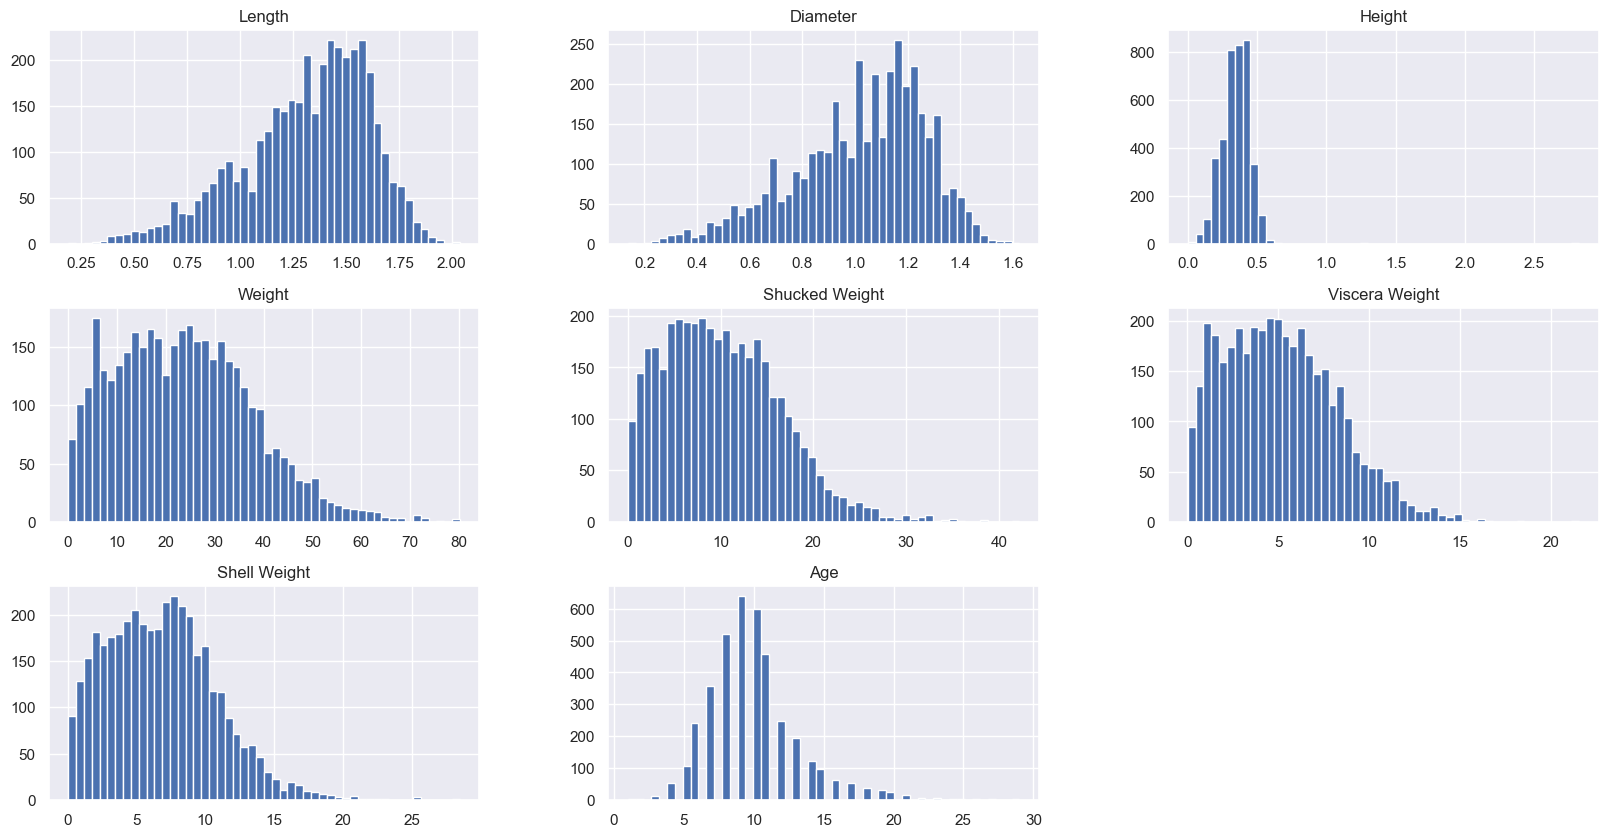

In [32]:
%%time
# Plotting the distribution of the features
crabs.hist(figsize=(20, 10), bins=50)


#### Observations: Histogram

- `Length` and `Diameter` features have a similar distribution.
    - Makes me wonder if they are correlated as well.
- `Height` has a very skewed distribution.
    - Log transformation may help here.
- All `*Weight` features have distribution skewed low.
    - Normalization might help here as well.
- `Age` seems to have a normal distribution.
    - This is good for regression tasks.
        - We won't have to worry about oversampling or undersampling.
    - They must estimate the age of the crab with mainly even numbers.


#### Show the Box Plots

Another type of distribution visualization, box plots give us more insight on the outliers.


CPU times: total: 62.5 ms
Wall time: 83.2 ms


Length               Axes(0.125,0.653529;0.227941x0.226471)
Diameter          Axes(0.398529,0.653529;0.227941x0.226471)
Height            Axes(0.672059,0.653529;0.227941x0.226471)
Weight               Axes(0.125,0.381765;0.227941x0.226471)
Shucked Weight    Axes(0.398529,0.381765;0.227941x0.226471)
Viscera Weight    Axes(0.672059,0.381765;0.227941x0.226471)
Shell Weight             Axes(0.125,0.11;0.227941x0.226471)
Age                   Axes(0.398529,0.11;0.227941x0.226471)
dtype: object

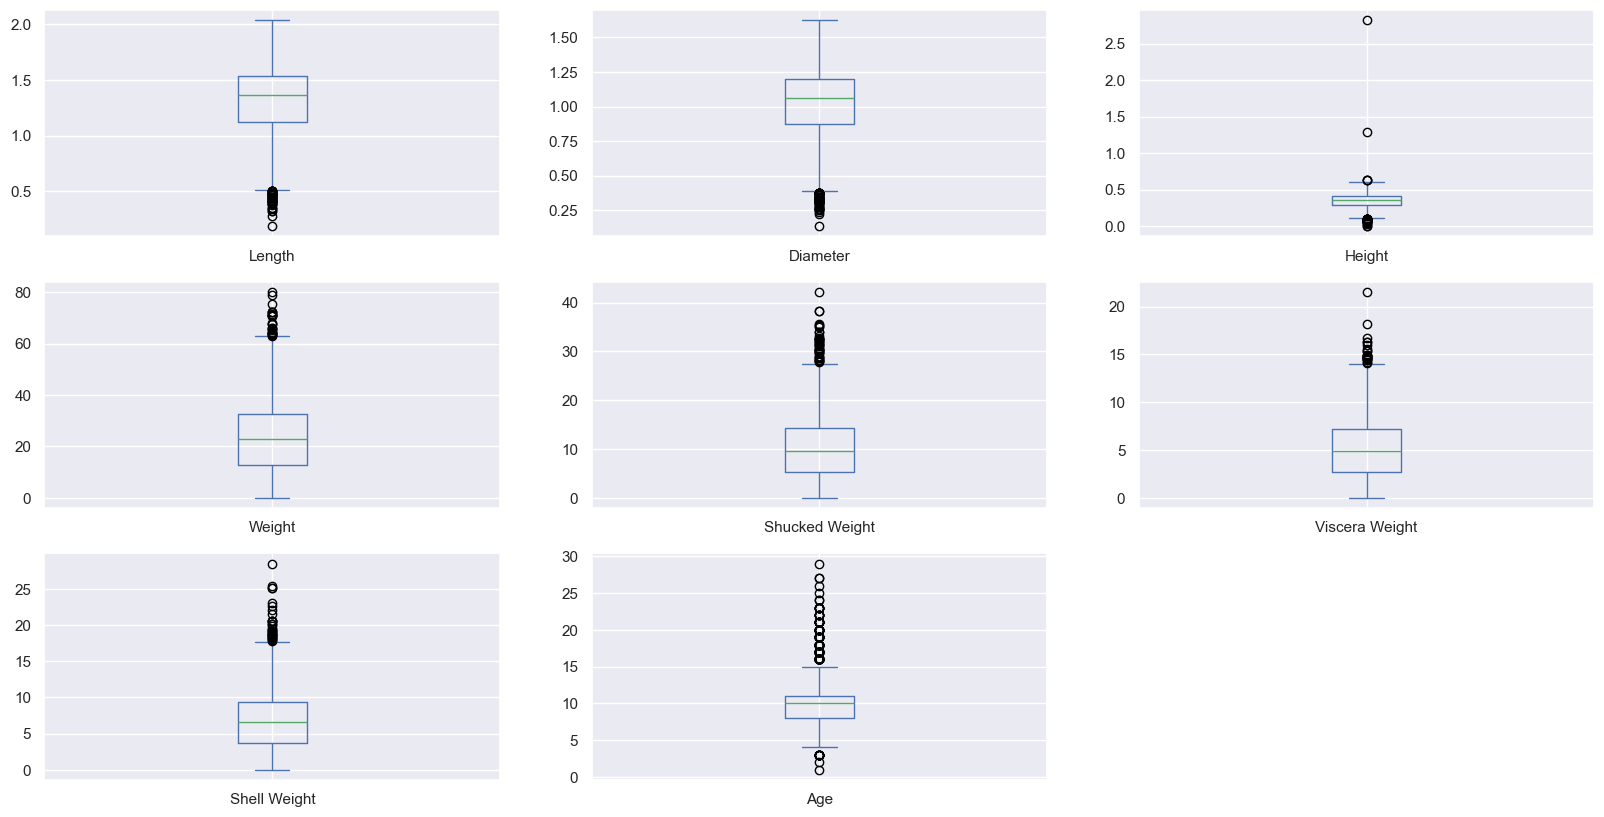

In [33]:
%%time
# Plotting the box plot of the features
crabs.plot(kind='box', subplots=True, layout=(3,3), sharex=False, sharey=False, figsize=(20, 10))


#### Box Plot Observations

- `Height` has a relatively huge difference in the largest outliers.
    - Perhaps outlier removal is needed for this feature.
- `Length` and `Diameter` features have outliers trending downwards.
- All `*Weight` features have outliers trending upwards.
    - This suggests there are some mega-crabs to catch out there!
- `Age` has a few outliers trending upwards.
    - Perhaps we should remove much older crabs, since they grow slowly if at all after a certain age.

### Data Cleanup from Observations

- Remove outliers from Height.
- Remove outliers from Age.

*Why not ignore our problems?*


In [34]:
%%time
def remove_outliers(df:pd.DataFrame, col:str, keep_quantile:float=0.99) -> pd.DataFrame:
    """Remove outliers from the DataFrame.

    :param df: The data.
    :param col: The column to remove outliers from.
    :param keep_quantile: The quantile to keep.
    :return: The data without outliers.
    """
    assert col in df.columns, f'Column "{col}" not found in DataFrame.'
    assert 0 < keep_quantile < 1, f'Quantile "{keep_quantile}" must be between 0 and 1.'
    # remove outliers above the given quantile
    df = df[df[col] < df[col].quantile(keep_quantile)]
    return df

print(f'Original shape: {crabs.shape}')
crabs = remove_outliers(crabs, 'Height', 0.99)
print(f'Shape after removing outliers from "Height": {crabs.shape}')
crabs = remove_outliers(crabs, 'Age', 0.99)
print(f'Shape after removing outliers from "Age": {crabs.shape}')


Original shape: (3893, 11)
Shape after removing outliers from "Height": (3844, 11)
Shape after removing outliers from "Age": (3790, 11)
CPU times: total: 0 ns
Wall time: 1.51 ms


#### Show the Distribution Plots Again

Let's see how the data looks after removing the outliers.

CPU times: total: 93.8 ms
Wall time: 195 ms


array([[<Axes: title={'center': 'Length'}>,
        <Axes: title={'center': 'Diameter'}>,
        <Axes: title={'center': 'Height'}>],
       [<Axes: title={'center': 'Weight'}>,
        <Axes: title={'center': 'Shucked Weight'}>,
        <Axes: title={'center': 'Viscera Weight'}>],
       [<Axes: title={'center': 'Shell Weight'}>,
        <Axes: title={'center': 'Age'}>, <Axes: >]], dtype=object)

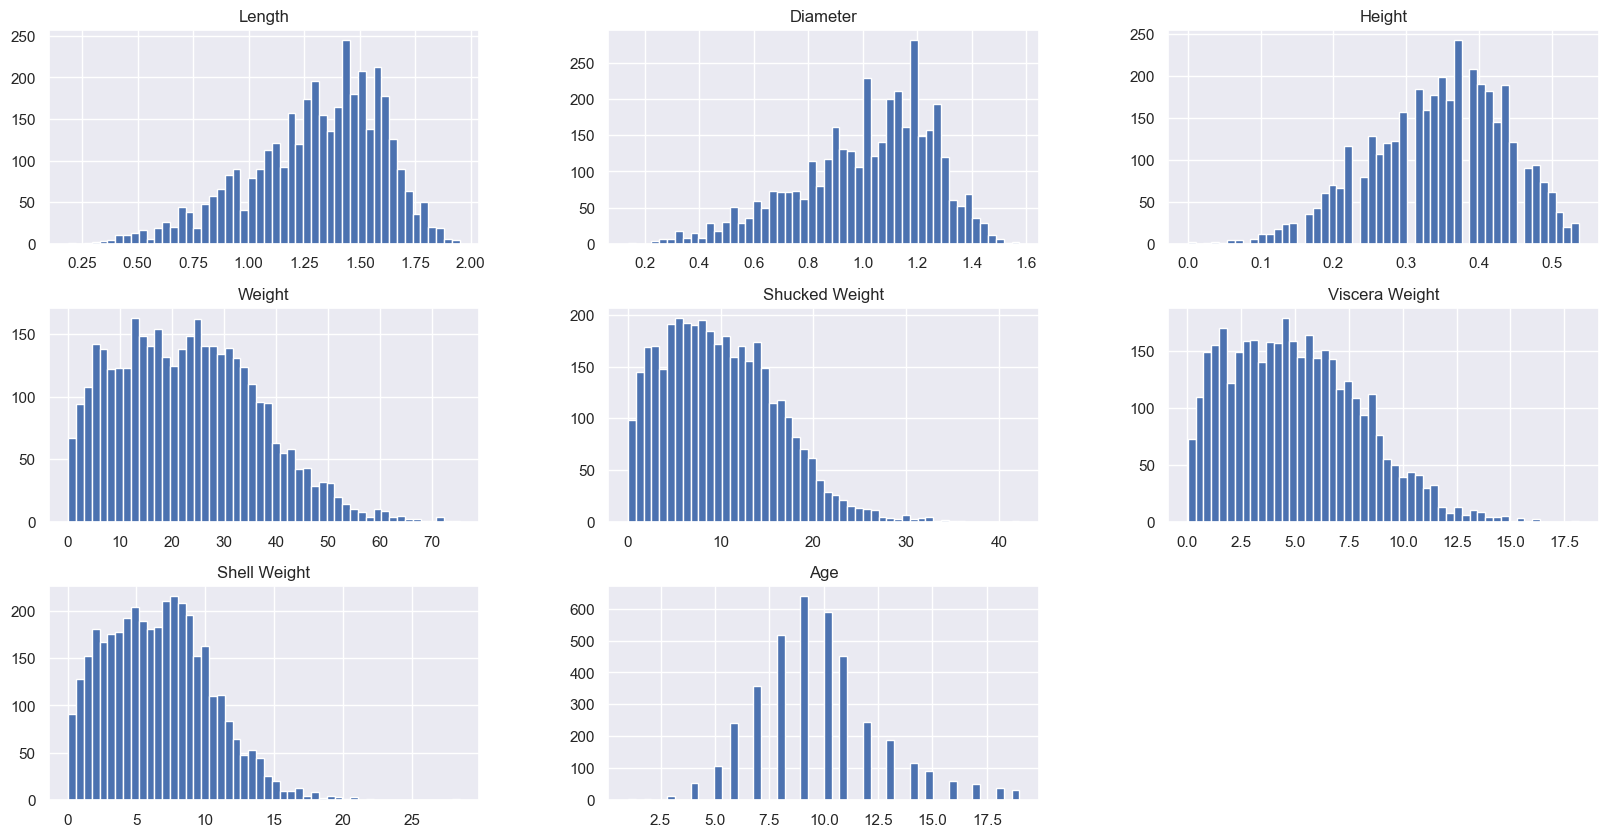

In [35]:
%%time
# Plotting the distribution of the features
crabs.hist(figsize=(20, 10), bins=50)


CPU times: total: 31.2 ms
Wall time: 83.6 ms


Length               Axes(0.125,0.653529;0.227941x0.226471)
Diameter          Axes(0.398529,0.653529;0.227941x0.226471)
Height            Axes(0.672059,0.653529;0.227941x0.226471)
Weight               Axes(0.125,0.381765;0.227941x0.226471)
Shucked Weight    Axes(0.398529,0.381765;0.227941x0.226471)
Viscera Weight    Axes(0.672059,0.381765;0.227941x0.226471)
Shell Weight             Axes(0.125,0.11;0.227941x0.226471)
Age                   Axes(0.398529,0.11;0.227941x0.226471)
dtype: object

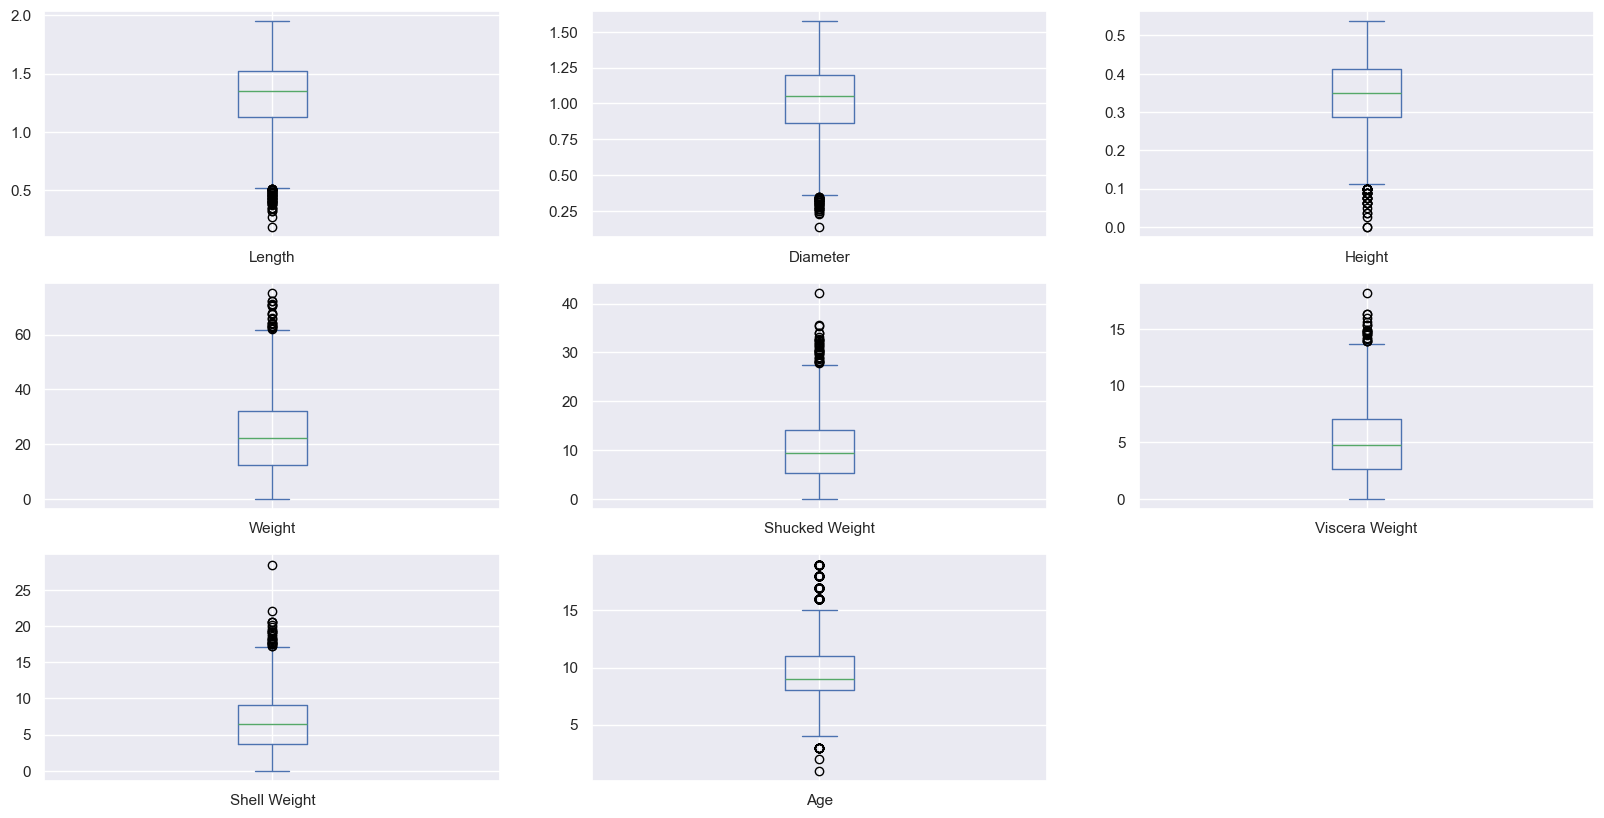

In [36]:
%%time
crabs.plot(kind='box', subplots=True, layout=(3,3), sharex=False, sharey=False, figsize=(20, 10))


##### That's better!

Height and Age have more normal distributions now.

In [37]:
%%time
def data_normalization(df:pd.DataFrame, a:float=-1., b:float=1., df_min:pd.Series=None,  df_max:pd.Series=None) -> pd.DataFrame:
    """Normalize the DataFrame from a to b.
    
    :param df: The data.
    :param a: The minimum value.
    :param b: The maximum value.
    :param df_min: The minimum value of the data.
    :param df_max: The maximum value of the data.
    :return: The normalized data.
    """
    # scale the data to a range of [a, b]
    df_min = df.min() if df_min is None else df_min
    df_max = df.max() if df_max is None else df_max
    df = a + ((df - df_min) * (b - a)) / (df_max - df_min)
    return df


CPU times: total: 0 ns
Wall time: 0 ns


### Data Correlation

#### Show the Heatmap

To see a likelihood of each feature correlating with our prediction target.


CPU times: total: 15.6 ms
Wall time: 57.1 ms


<Axes: title={'center': 'Correlation Graph'}>

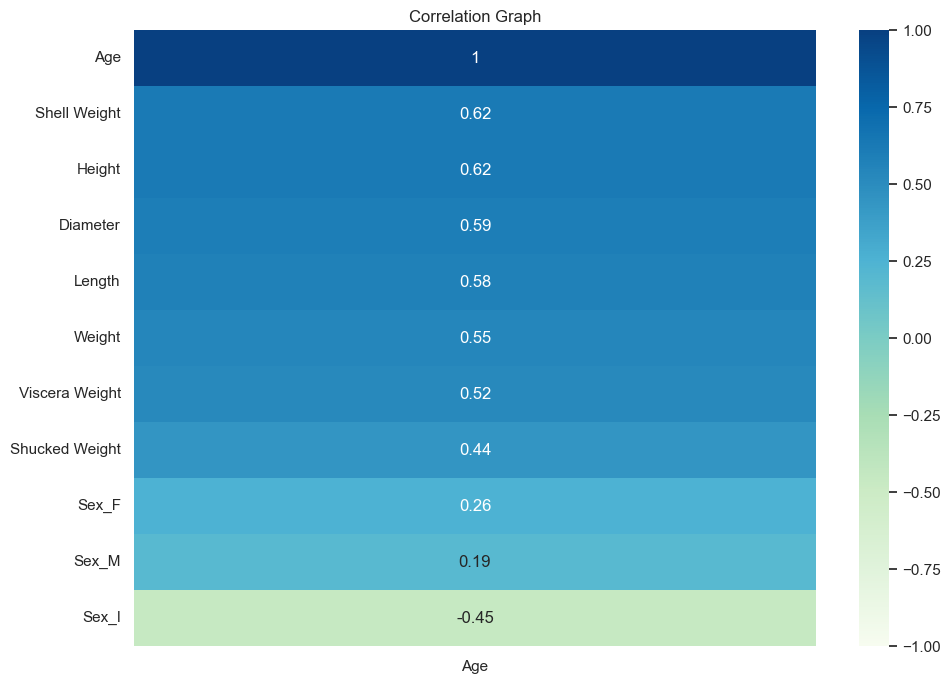

In [38]:
%%time
sns.set()
plt.figure(figsize = (11,8))
plt.title('Correlation Graph')
# Plotting the heatmap to check the correlation between the Target Label and other features
sns.heatmap(crabs.corr()[[PREDICTION_TARGET]].sort_values(by=PREDICTION_TARGET, ascending=False), vmin=-1, vmax=1, annot=True, cmap='GnBu')


#### Observations: Heatmap

- `Shell Weight` has the highest correlation with `Age`.
    - Crabs must grow thicker shells as they get older.
 

#### Show the Pair Plot

Another way to see how the data correlates with our prediction target. This will show us how the features correlate with each other as well.


In [ ]:
%%time
# Plotting the pair plot to check the correlation between the Target Label and other features
sns.pairplot(crabs, hue=PREDICTION_TARGET)
plt.title('Pair Plot Graphs')


#### Observations: Pair Plot

- `Length` and `Diameter` are highly correlated.
    - This makes sense since they are both measurements of the same thing.
- Many of the different weight measurements are correlated.
    - Multicollinearity might be an issue here. 

A great explanation of the pair plot can be found at [the stats stackexchange](https://stats.stackexchange.com/a/636122).

We'll use this information in the feature engineering step.


## Data Normalization

Crabs come in all shapes and sizes. Let's normalize the data to help our model make better sense of it.

![Tiny crab](https://www.popsci.com/uploads/2022/02/09/fiddler-crab.jpg?auto=webp&optimize=high&width=1440)

The book *Designing Machine Learning Systems* (Huyen, 2022) suggests normalizing to a range of [-1, 1] helps in practice.

Data normalization can help avoid data leakage based on the "form" of the data.


In [ ]:
%%time
def data_normalization(df:pd.DataFrame, a:float=-1., b:float=1., df_min:pd.Series=None,  df_max:pd.Series=None) -> pd.DataFrame:
    """Normalize the DataFrame from a to b.
    
    :param df: The data.
    :param a: The minimum value.
    :param b: The maximum value.
    :param df_min: The minimum value of the data.
    :param df_max: The maximum value of the data.
    :return: The normalized data.
    """
    # scale the data to a range of [a, b]
    df_min = df.min() if df_min is None else df_min
    df_max = df.max() if df_max is None else df_max
    df = a + ((df - df_min) * (b - a)) / (df_max - df_min)
    return df


### Split the Data

Let's split the data into training and testing sets.

It is important to split the data before any data augmentation or normalization to avoid data leakage.  
Data leakage lets the model learn from the testing data, which can lead to overfitting.

In more general terms, *data leakage* is the phenomenon when the form of a label "leaks" into the training feature set.
An example this of occurred in 2021 for diagnosing Covid patients. Patients lying down on a bed were more likely to be "diagnosed" with Covid.
This is because patients confirmed to have Covid were more inclined to bed rest (Huyen, 2022). 

#### Importance of Data Shuffling

Shuffling the data is important to avoid any biases in the data.
The order of data shouldn't matter, so shuffling helps mitigate any biases.

Shuffling should occur before the test-train split to be most effective.

We don't have to worry about time-series data right now
(although we could reverse order by 'Age' and call it time-series by new feature 'Crab Birthdate'),
but shuffling can have a big impact on the model's performance.


In [ ]:
%%time
# split features from target
X = crabs.drop([PREDICTION_TARGET], axis=1)
y = crabs[PREDICTION_TARGET]

# 80% training, 20% testing
train_size = int((1. - VALIDATION_SPLIT) * len(X))

# shuffle the data
random_indices = np.random.default_rng(42).permutation(np.arange(len(X)))

# split into train/test sets
X_train = X.iloc[random_indices[1:train_size]]
X_test = X.drop(X_train.index)
y_train = y.iloc[random_indices[1:train_size]]
# save the prediction target
y_test = y.drop(y_train.index)

assert X_train.shape[0] == y_train.shape[0]
assert X_test.shape[0] == y_test.shape[0]


### Normalize the Data

Ensure we're only normalizing using parameters from the training data to prevent data leakage.

We are not going to save this data, as we will include a normalizer in the model itself. This is purely for educational purposes.


In [ ]:
%%time
# normalize the data
normalized_train = pd.DataFrame()
for col in X_train.select_dtypes(include=[np.number]).columns:
    normalized_train[col] = data_normalization(X_train[col])
normalized_train.describe().transpose()[['mean','std']]


In [ ]:
%%time
# apply the same normalization to the test data
normalized_test = pd.DataFrame()
for col in X_test.select_dtypes(include=[np.number]).columns:
    normalized_test[col] = data_normalization(X_test[col], df_min=X_train[col].min(), df_max=X_train[col].max())
normalized_test.describe().transpose()[['mean','std']]


#### Show Distributions After Normalization

Shape of the distribution should remain nearly the same, but the range should be [-1, 1].


In [ ]:
%%time
# Plotting the distribution of the features
normalized_train.hist(figsize=(20, 10), bins=50)
plt.title('After Normalization')


## Save the Data

So we can pick this back up on the [next step](../0-eda/overfit.ipynb).

I chose to save the data in the [Feather](https://github.com/apache/arrow) format because it retains the data types.

It's also faster to read and write than CSV. Check out this comparison of file formats for saving pandas data: 
https://towardsdatascience.com/the-best-format-to-save-pandas-data-414dca023e0d


In [ ]:
%%time
# create the cache directory if it doesn't exist
pathlib.Path('../cache').mkdir(parents=True, exist_ok=True)

# save the training and test data separately
pd.concat([X_train, y_train], axis=1, join='outer').to_feather(NEXT_CACHE_FILE)
pd.concat([X_test, y_test], axis=1, join='outer').to_feather(NEXT_CACHE_FILE.replace('.feather', '_test.feather'))


## Onwards to Overfitting

See the [next section](../0-eda/overfit.ipynb) to overfit on purpose.

[`<html link>`](https://nbviewer.jupyter.org/github/ahester57/ai_workshop/blob/master/notebooks/time_for_crab/0-eda/overfit.ipynb) for overfitting.
